[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)
- Click "Upload" and select this file and the data file.

# Bank customers: Random Forests

Goal : Build a decision tree classification algorithm for bank customers' response to marketing campaign.
- purchase: whether the client purchased a term deposit (yes, no)
- age
- job: type of job (admin, bluecollar, entrepreneur, housemaid, management, retired, selfemployed, services, student, technician, unemployed)
- marital: marital status (divorced/widowed, married, single)
- education (primary, secondary, tertiary)
- default: has credit in default? (yes, no)
- balance: average yearly balance, in euros
- housing: has housing loan? (yes, no)
- loan: has personal loan? (yes, no)
- day, month: last contact day and month
- duration: last contact duration, in seconds
- campaign: number of contacts performed during this campaign and for the client
- passdays: number of days that passed by after the client was last contacted from a previous campaign
- previous: number of contacts performed before this campaign

In [1]:
# conda update -n base -c defaults conda

In [2]:
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV

from io import StringIO
import pydotplus
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from IPython.display import Image
import graphviz

### Prepare data

In [4]:
# Read the data

df = pd.read_csv('Bank customer.csv')
print(df.shape)
df.head()

(43193, 15)


,deposit,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,passdays,previous
0,no,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0
1,no,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0
2,no,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0
3,no,35,management,married,tertiary,no,231,yes,no,5,may,139,1,-1,0
4,no,28,management,single,tertiary,no,447,yes,yes,5,may,217,1,-1,0


* `df.shape`: output is a tuple (rows, columns) in the dataframe.

In [5]:
# Encode 'deposit' (binary variable)

df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df.head()

,deposit,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,passdays,previous
0,0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0
1,0,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0
2,0,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0
3,0,35,management,married,tertiary,no,231,yes,no,5,may,139,1,-1,0
4,0,28,management,single,tertiary,no,447,yes,yes,5,may,217,1,-1,0


-  `df['deposit'].apply(lambda x: 1 if x=='yes' else 0)`: Convert the 'deposit' column from categorical values 'yes' and 'no' to binary values 1 and 0, respectively.
    - `apply(lambda x: ...)`: Apply a lambda function to each value in the 'deposit' column.
    - `lambda x: 1 if x=='yes' else 0`: Check each value `x` in the 'deposit' column. If `x` is 'yes', returns 1. Otherwise, return 0.

In [6]:
# Encode 'month' (change into numbers)

mth = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = df['month'].apply(lambda x: mth.index(x)+1)
df.head()

,deposit,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,passdays,previous
0,0,58,management,married,tertiary,no,2143,yes,no,5,5,261,1,-1,0
1,0,44,technician,single,secondary,no,29,yes,no,5,5,151,1,-1,0
2,0,33,entrepreneur,married,secondary,no,2,yes,yes,5,5,76,1,-1,0
3,0,35,management,married,tertiary,no,231,yes,no,5,5,139,1,-1,0
4,0,28,management,single,tertiary,no,447,yes,yes,5,5,217,1,-1,0


- `df['month'].apply(lambda x: mth.index(x)+1)`: Converts the 'month' column in the df from categorical month names to corresponding numerical values.
- `lambda x: mth.index(x)+1`: The lambda function takes each value `x` (=months) and finds its index in the `mth` list using the `index()` method.
    - Since list indices start from 0, we add 1 to get the correct month number (e.g., 'jan' would be at index 0 in the `mth` list, but we want January to be represented as 1).
- After executing this code, the 'month' column in `df` will have month abbreviations replaced with their numeric values, with January as 1 and December as 12.

In [7]:
# Create dummies from the categorical variables

df = pd.get_dummies(df, columns=['job','marital','education','default','housing','loan'], drop_first=True)
df.head()

,deposit,age,balance,day,month,duration,campaign,passdays,previous,job_blue-collar,...,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes
0,0,58,2143,5,5,261,1,-1,0,0,...,0,0,0,1,0,0,1,0,1,0
1,0,44,29,5,5,151,1,-1,0,0,...,0,1,0,0,1,1,0,0,1,0
2,0,33,2,5,5,76,1,-1,0,0,...,0,0,0,1,0,1,0,0,1,1
3,0,35,231,5,5,139,1,-1,0,0,...,0,0,0,1,0,0,1,0,1,0
4,0,28,447,5,5,217,1,-1,0,0,...,0,0,0,0,1,0,1,0,1,1


* `get_dummies`: Creates new binary (0 or 1) columns for categorical variables such as job, marital, eduction,default, housing and loan
* `drop_first`: prevents multicollinearity by omitting one of the binary columns per categorical variable. The original variable will be also dropped.

In [8]:
# Define x and y. Split into train, test data

y=df.deposit
x=df.drop('deposit', axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=1)

- `df.drop('deposit', axis=1)`: Removes the 'deposit' column (axis=1) from the DataFrame.
- `random_state`: Used to control the randomness to ensure reproducibility. It allows you to get the same results when running your code multiple times, as long as you use the same value for random_state.

### Random forests

In [9]:
#  Define and fit a decision tree model on the data

m1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1).fit(xtrain, ytrain)

- RandomForestClassifier()
  - `n_estimators=100`: It specifies the number of decision trees that will be included in the forest.
  - `max_depth=5`: It sets the maximum depth of each decision tree in the forest.
  - `fit(xtrain, ytrain)`: Fits the Random Forest classifier with the training data.

<Figure size 500x500 with 0 Axes>

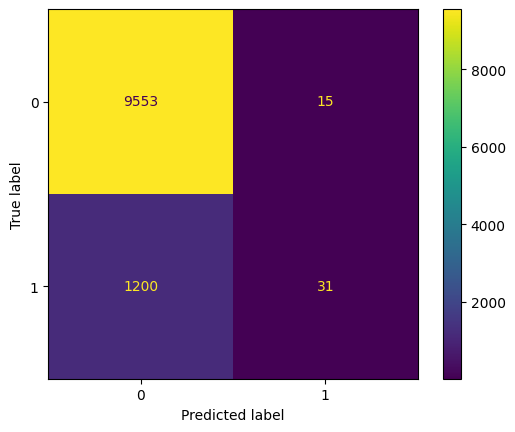

In [10]:
# Predict the target in the test data and display confusion matrix

pred1 = m1.predict(xtest)
plt.figure(figsize=(5,5))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, pred1)).plot()

- `m1.predict(xtest)`: It uses the trained Random Forest classifier (m1) to make predictions on the test dataset (xtest).
- `confusion_matrix(ytest, pred1)`: The confusion matrix shows the true positive, true negative, false positive, and false negative counts for a set of predictions compared to the true labels (ytest).
- `ConfusionMatrixDisplay()`: creaties a visual representation of a confusion matrix.

In [11]:
print('Accuracy:', metrics.accuracy_score(ytest, pred1))
print('F1:', metrics.f1_score(ytest, pred1))

Accuracy: 0.8874895823687379
F1: 0.04855129209083791


- `metric.accuracy_score`: calculates the accuracy of the predicted compared to the actual target values (ytest).

In [12]:
# Classification report

print(classification_report(ytest, pred1))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9568
           1       0.67      0.03      0.05      1231

    accuracy                           0.89     10799
   macro avg       0.78      0.51      0.49     10799
weighted avg       0.86      0.89      0.84     10799



- `classification report`: summarizies various metrics such as precision, recall, F1-score, and support for each class based on the predictions (pred) and actual labels (ytest).
- precision: the ratio of true positive predictions to the total number of positive predictions.
- recall: the ratio of true positive predictions to the total number of actual positive instances
- F1-score: combines both precision and recall into a single value, providing a balance between the two metrics for evaluating classification model performance.
- support: the number of occurrences of a specific class.

### Visualization
- Uncomment and install the pydotplus and graphviz libraries if you haven't.

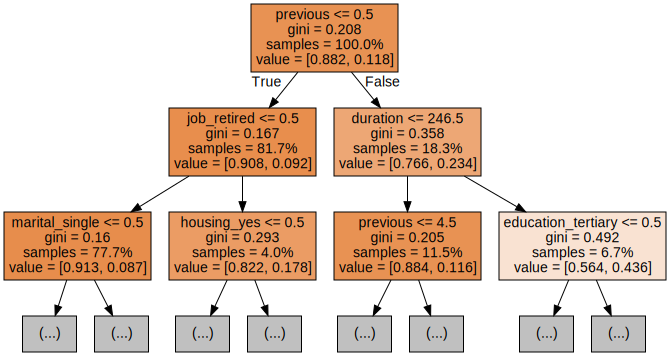

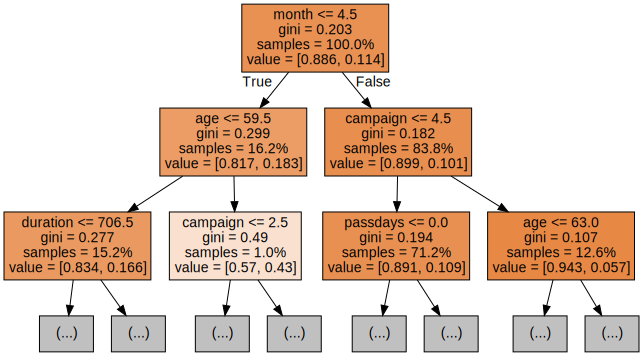

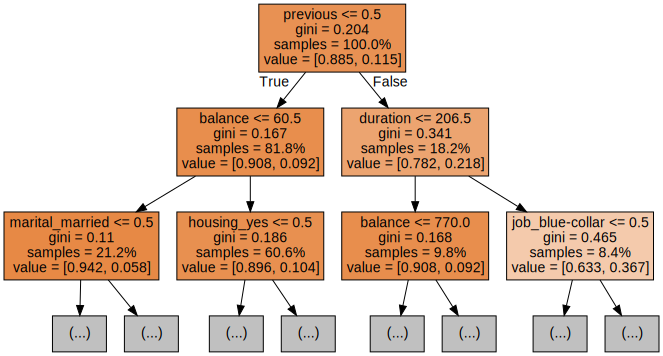

In [13]:
# Display decision trees from the random forest

for i in range(3):
    tree = m1.estimators_[i]
    dot = export_graphviz(tree, feature_names=xtrain.columns, max_depth=2, proportion=True, filled=True)
    graph = graphviz.Source(dot)
    display(graph)

- `for i in range(3)`: The for loop iterates three times, and for each iteration, it selects the i-th decision tree from the estimators_ attribute of the random forest model.
- `tree=m1.estimators_[i]`: m1.estimators_ selects the i-th decision tree from the Random Forest and assigns it to the tree variable.
- `dot = export_graphviz(tree, feature_names=xtrain.columns, max_depth=2, proportion=True)`
     - `tree': the decision tree object
     - `xtrain.columns`: the names of the features
     - max_depth=2: sets the maximum depth to which the tree will be visualized.
     - proportion=True: changes the display of 'samples' and 'values' to proportions.
         - value refers to the number of samples that fall into the node.
     - filled=True: fills the nodes with color to indicate majority class.
         - The colors get darker the closer the node gets to being 0 or 1.
- `graphviz.Source(dot)`: Create a visualization of the decision tree from the DOT format data (dot) generated in the previous step. It creates a Source object that holds the graphical representation of the decision tree.

### Hyperparameter tuning

In [14]:
# Use random search to find the best hyperparameters (It will take some time)

m2 = RandomForestClassifier()
param = {'n_estimators': randint(50,200), 'max_depth': randint(5,20)}
search=RandomizedSearchCV(m2, param_distributions = param, n_iter=5, cv=5).fit(xtrain, ytrain)

- `param = {}` is a dictionary with two hyperparameters to tune
    - `randint()` generate random integers within a specified range. Any integer between 50 (inclusive) and 200 (exclusive) could be generated.
    - `n_estimators` and `max_depth`: The values are randomly sampled from a uniform distribution from the range specified in `randint()`
    - The possible number of combinations will be 150*15=2250 (50-199 for n_estimators, 5-19 for max_depth).
- `RandomizedSearchCV(m, param_distributions = param, n_iter=5, cv=5)`
    - `RandomizedSearchCV` is a technique for hyperparameter optimization
        - Unlike grid search, which exhaustively tries all possible combinations of hyperparameters, randomized search takes a random sampling approach. It specifies a range or distribution for each hyperparameter and then randomly samples a set of hyperparameter combinations to evaluate.
        - Instead of specifying specific values for hyperparameters, you define distributions or ranges for the hyperparameters. The random search then samples from these distributions to create different combinations.
    - `n_iter`: specifies how many different combinations of hyperparameters should be tried during the randomized search.
        - The randomized search algorithm will randomly sample `n_iter`(=5 in this case) different sets of hyperparameters from the specified parameter distributions.
        - After `n_iter` iterations, the algorithm selects the best set of hyperparameters based on the specified performance metric.
    - `cv`: the number of cross-validation folds. It evaluates the model's performance using cross-validation for each set of hyperparameters.
    - `param_distributions`: specifies the range of values for each hyperparameter that will be considered during the search.

In [15]:
# Create a variable for the best model

best = search.best_estimator_
print('Best hyperparameters:',  search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 91}


- `search.best_estimator_`: extracts the best estimator from the search object.

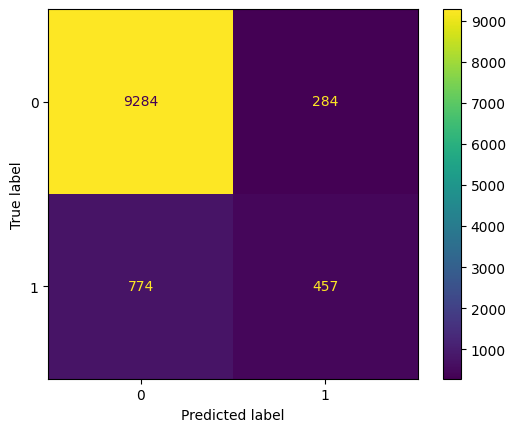

In [16]:
pred2 = best.predict(xtest)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, pred2)).plot();

In [17]:
# Classification report

print(classification_report(ytest, pred2))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9568
           1       0.62      0.37      0.46      1231

    accuracy                           0.90     10799
   macro avg       0.77      0.67      0.70     10799
weighted avg       0.89      0.90      0.89     10799



- Accuracy increased from 88% to 90%
- F1 increased from 5% to 47%.

<Axes: >

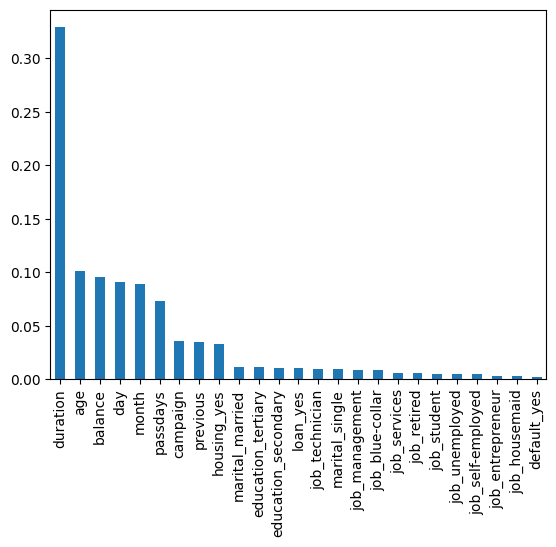

In [18]:
# Create a series containing feature importances from the model and feature names from the training data

imp = pd.Series(best.feature_importances_, index=xtrain.columns).sort_values(ascending=False)
imp.plot.bar()

- `pd.Series(best.feature_importances_, index=xtrain.columns)`: calculates the feature importances
    - `best.feature_importances_` provides an array of feature importances from the model that performed the best during the search.
    - xtrain.columns provides the names of the features.
    - The importances are combined into a pandas Series, where the feature names are used as the index.
- `sort_values(ascending=False)`: sorts the features in descending order of importance.
- `imp.plot.bar()`: generates a bar plot to visualize the sorted feature importances.

- Duration has the highest impact on the target variable.